# Finding Donors for *CharityML*  
## Supervised Machine Learning
### by Mohamad Zeini Jahromi

## Getting Started

In this project, We will employ several supervised algorithms of our choice to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [76]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [77]:
# Total number of records
n_records = data['income'].count()

# Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / n_records *100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

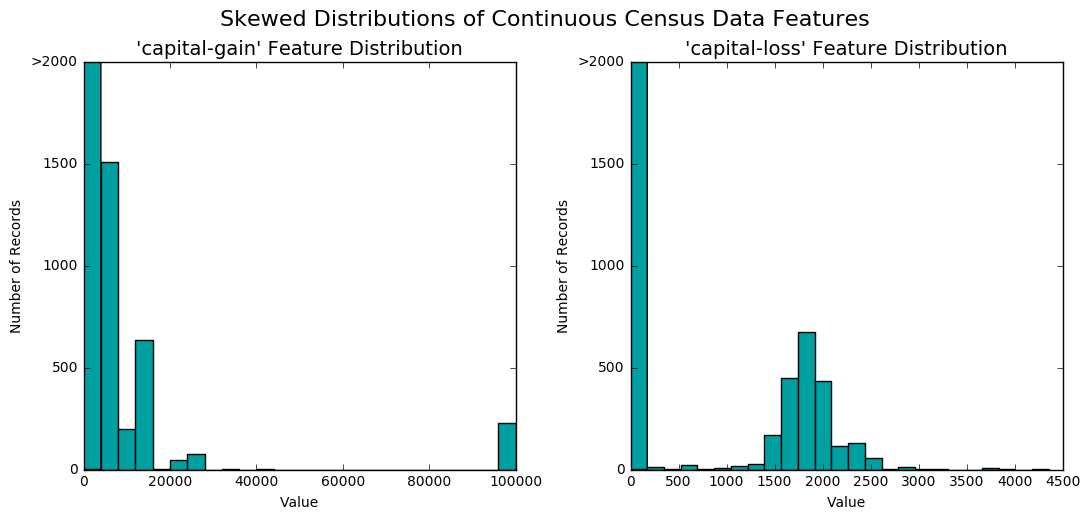

In [78]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

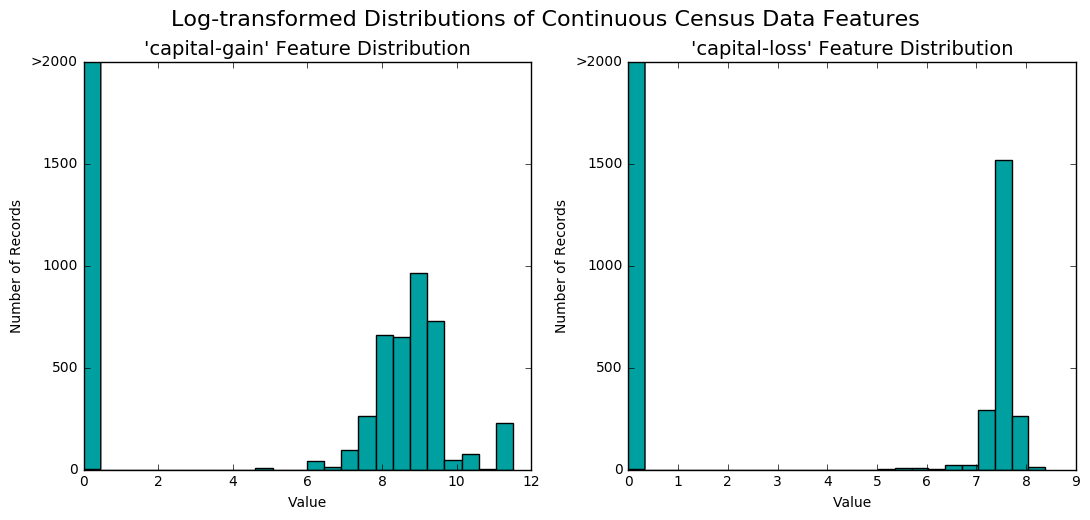

In [79]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [80]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will  implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [81]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names 
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [82]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of our choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? We use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [83]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
accuracy = float(np.sum(income)) / income.count() 
recall = float(np.sum(income)) / np.sum(income)
precision = float(np.sum(income)) / income.count()

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application
We are going to choose three of the supervised learning models above that are appropriate for this problem that we will test on the census data. In the following section, for each model, we will describe and answer; 

- Real-world applications in industry where the model can be applied. 
- Strengths of the model; when does it perform well?
- Weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what we know about the data

* **Gaussian Naive Bayes (GaussianNB)**

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.It was introduced under a different name into the text retrieval community in the early 1960s[1] and remains a popular (baseline) method for text categorization, the problem of judging documents as belonging to one category or the other (such as spam or legitimate, sports or politics, etc.) with word frequencies as the features. With appropriate pre-processing, it is competitive in this domain with more advanced methods including support vector machines.[2] It also finds application in automatic medical diagnosis. Despite their naive design and apparently oversimplified assumptions, naive Bayes classifiers have worked quite well in many complex real-world situations. A comprehensive comparison with other classification algorithms showed that Bayes classification is outperformed by other approaches, such as boosted trees or random forests. An advantage of naive Bayes is that it only requires a small number of training data to estimate the parameters necessary for classification. The accuracy is relatively low but the prediction speed is fast. One limitation of this model is that it can’t learn interactions between features but can handle lots of features.

* **Decision Trees**

Algorithms for constructing decision trees usually work top-down, by choosing a variable at each step that best splits the set of items.[3] Different algorithms use different metrics for measuring "best". These generally measure the homogeneity of the target variable within the subsets. Some examples are *information gain* and *variance reduction*. These metrics are applied to each candidate subset, and the resulting values are combined (e.g., averaged) to provide a measure of the quality of the split.  Medical research and practice have long been important areas of application for decision tree techniques. Recent uses of automatic induction of decision trees can be found in diagnosis, cardiology, psychiatry and gastroenterology. Decision trees have various advantages such as; simple to understand and interpret, able to handle both numerical and categorical data, requires little data preparation, and performs well with large datasets. Large amounts of data can be analysed using standard computing resources in reasonable time. They easily handle feature interactions and they’re non-parametric, so you don’t have to worry about outliers or whether the data is linearly separable. On the other hand, Trees can be very non-robust. A small change in the training data can result in a big change in the tree, and thus a big change in final predictions. Another limitation is that decision-tree learners can create over-complex trees that do not generalize well from the training data. (This is known as overfitting.[4]) These models are a good classifier for large datasets with small numbers of features. 

* **Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)**

Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.[5] Ensembles may be thought of as a way to compensate for poor learning algorithms by performing a lot of extra computation. Fast algorithms such as decision trees are commonly used in ensemble methods (for example Random Forest), although slower algorithms can benefit from ensemble techniques as well. Empirically, ensembles tend to yield better results when there is a significant diversity among the models.[6] One common type of ensembles is Boosting. Boosting involves incrementally building an ensemble by training each new model instance to emphasize the training instances that previous models mis-classified. In some cases, boosting has been shown to yield better accuracy than bagging, but it also tends to be more likely to over-fit the training data. By far, the most common implementation of Boosting is Adaboost. AdaBoost can be used for face detection as an example of binary categorization. Unlike other powerful classifiers, such as SVM, AdaBoost can achieve similar classification results with much less tweaking of parameters or settings (unless of course you choose to use SVM with AdaBoost). This algorithm can be sensitive to noisy data and outliers. In some problems, it can be less susceptible to the overfitting problem than other learning algorithms. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner. It usually performs well on a big dataset including many features.

* **K-Nearest Neighbors (KNeighbors)**

In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. It is commonly used for its easy of interpretation and low calculation time. k-NN is often used in search applications where you are looking for “similar” items; that is, when your task is some form of “find items similar to this one”. You’d call this a k-NN search. The biggest use case of k-NN search might be Recommender Systems. A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data. The accuracy of the k-NN algorithm can be severely degraded by the presence of noisy or irrelevant features, or if the feature scales are not consistent with their importance. It performs well on large dataset but it can't handle high numbers of features. [7]


* **Stochastic Gradient Descent Classifier (SGDC)**

Stochastic gradient descent is a popular algorithm for training a wide range of models in machine learning, including (linear) support vector machines, logistic regression (see, e.g., Vowpal Wabbit) and graphical models. When combined with the backpropagation algorithm, it is the de facto standard algorithm for training artificial neural networks. Its use has been also reported in the Geophysics community, specifically to applications of Full Waveform Inversion (FWI).[8] SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. The advantages of Stochastic Gradient Descent are efficiency and ease of implementation (lots of opportunities for code tuning). The disadvantages of Stochastic Gradient Descent are that SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations and also SGD is sensitive to feature scaling.[9] 

* **Support Vector Machines (SVM)**

More formally, a support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. SVMs are helpful in text and hypertext categorization as their application can significantly reduce the need for labeled training instances in both the standard inductive and transductive settings. Classification of images can also be performed using SVMs.[10] In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. Support vector machines are effective in high dimensional spaces and still effective in cases where number of dimensions are greater than the number of samples. Also it uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. The disadvantages are that SVM algorithms are slow and if the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial. [11]

* **Logistic Regression**

In statistics, logistic regression, or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical. Logistic regression is used in various fields, including machine learning, most medical fields, and social sciences. For example, the Trauma and Injury Severity Score (TRISS), which is widely used to predict mortality in injured patients, was originally developed by Boyd et al. using logistic regression.[12] Another example might be to predict whether an American voter will vote Democratic or Republican, based on age, income, sex, race, state of residence, votes in previous elections, etc.[13] Logistic regression has several advantages over discriminant analysis such as; it is more robust, the independent variables don’t have to be normally distributed, or have equal variance in each group, it does not assume a linear relationship between the IV and DV, it may handle nonlinear effects. Disadvantages are that it requires large sample size to achieve stable results and can't handle many features effectively.

### Our Choice
From the list of the supervised learning models above, I choose three algorithms that are appropriate for this problem and I will test on the census data. These algorithms are; Support Vector Machines (SVM), AdaBoost, and Gaussian Naive Bayes (GaussianNB). These algorithms can handle lots of irrelevant features and perform well with large datasets. Decision Trees and K-Nearest Neighbors aren't suitable for high-dimensional cases and are prone to overfitting.


### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Set the `beta` parameter!

In [85]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    beta = 0.5
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)    
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)   
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model we use, if provided.
  - **Note:** We use the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


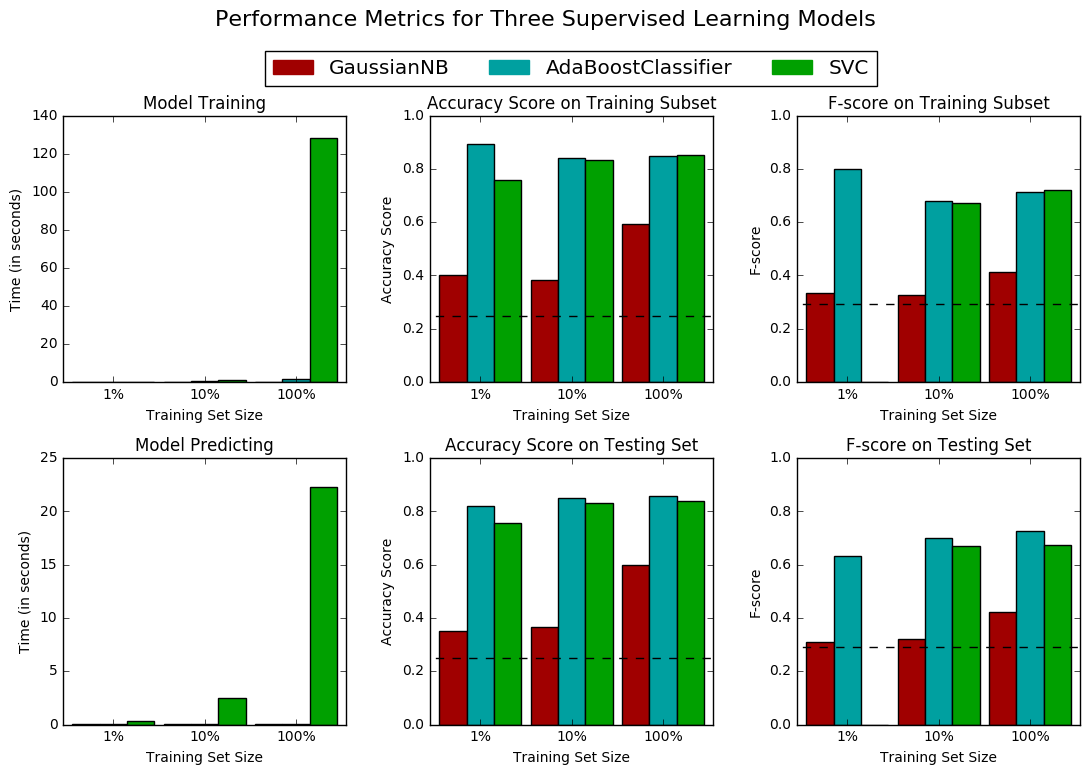

In [86]:
# Import the three supervised learning models from sklearn

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = svm.SVC(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = GaussianNB()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(X_train.shape[0]*1)
samples_10 = int(X_train.shape[0]*0.1)
samples_1 = int(X_train.shape[0]*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. we will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

Based on our evaluation, AdaBoost classifier seems to be the most appropriate one for the task of identifying individuals that make more than $50,000. AdaBoost classifier has the highest F-score and accuracy for the testing set when 100\% of the training set is used (0.78 and 0.82 respectively). SVC has also F-score and accuracy close to AdaBoost classifier but it has a long training and testing time comparing to AdaBoost (22 vs 2 seconds) which make it the second choice in terms of efficiency. More over, Gaussian Naive Bayes has lowest performance results although it has the fastest training and testing time.

### Describing the Model in Layman's Terms

If we want to describe the model in layman's terms, we would say, AdaBoost is a type of "Ensemble Learning" where multiple learners are employed to build a stronger learning algorithm. AdaBoost works by choosing a base algorithm (e.g. decision trees) and iteratively improving it by accounting for the incorrectly classified examples in the training set. We assign equal weights to all the training examples and choose a base algorithm. At each step of the iteration, we apply the base algorithm to the training set and increase the weights of the incorrectly classified examples. We iterate n times, each time applying base learner on the training set with updated weights. The final model is the weighted sum of the n learners. AdaBoost is extremely successful machine learning method and Schapire and Freund won the Godel Prize in 2003 for their construction of AdaBoost algorithm.[14]

AdaBoost is sensitive to noisy data and outliers. In some problems it can be less susceptible to the overfitting problem than other learning algorithms. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing (e.g., their error rate is smaller than 0.5 for binary classification), the final model can be proven to converge to a strong learner. Every learning algorithm will tend to suit some problem types better than others, and will typically have many different parameters and configurations to be adjusted before achieving optimal performance on a dataset, AdaBoost (with decision trees as the weak learners) is often referred to as the best out-of-the-box classifier.[15]  It usually performs well on big datasets which include many features like CharityML dataset.

### Model Tuning
Here we fine tune the chosen model. We use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will use the entire training set for this. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state we set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [87]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = parameters = {'n_estimators': [10, 20, 40, 100,150,200],
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate': [.5, 1, 1.5, 2]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8645
Final F-score on the testing data: 0.7375


### Final Model Evaluation

The following table shows our optimized model's accuracy and F-score on the testing data along with the results from our unoptimized model and the naive predictor benchmarks we found earlier.  

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |      0.8576       |     0.8645      |
| F-score        |       0.2917        |      0.7246       |     0.7375      |


The above table shows optimized model's accuracy and F-score on the testing data are 0.8645 and 0.7375 respectively which are slightly better than the unoptimized model. The hyperparameters tuning using grid search (GridSearchCV) were effective for our model. Our optimized model performed significantly better than the Naive Predictor. The accuracy changed from 0.2478 to 0.8645 and F-score changed from 0.2917 to 0.7375.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We chose a scikit-learn classifier (Adaboost) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell, we fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.

Since we are trying to find individuals with higher income (greater than \$50K), out of these thirteen records, we believe the following five features to be most important for prediction. The order of importance is from top to bottom.

* **capitals-gain**, because it's directly related to the level of income.

* **capitals-loss**, since it directly affects the income level.

* **education-num**, Having higher education increase the someone's potential to have a better job and higher income.

* **hours-per-week**, People who work more hours-per-week supposedley make more money.

* **age**, As people get older and more experienced, they more likely achieve higher positions and payrolls. 


### Extracting Feature Importance
We chose a `Adaboost` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we will implement the following:
 - Import our Adaboost supervised learning model from sklearn.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

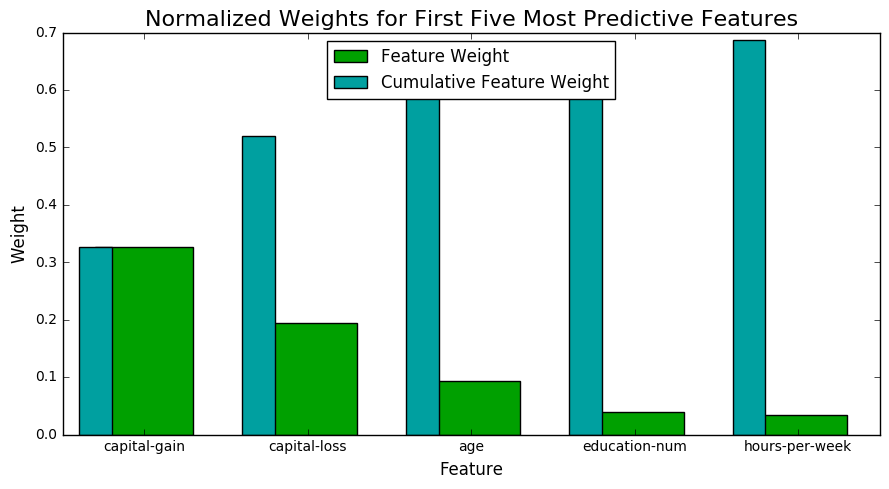

In [88]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf.fit(X_train,y_train)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Observing the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000, we can say, our initial guess of top five features is the same as what *feature_importance_ attribute* presents. The only difference is that age is ranked 3rd rather than 5th. It appears that being older and more experience play a stronger role in income level than factors like education-num or hour-per-week.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [69]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8645
F-score on testing data: 0.7375

Final Model trained on reduced data
------
Accuracy on testing data: 0.8379
F-score on testing data: 0.6898


### Effects of Feature Selection

The final model's F-score and accuracy drops slightly (0.05 of F-score and 0.03 of accuracy). Therefore we can say our model's prediction is mostly based on the top five features. In the case of having large datasets which training time is an important issue, it's reasonable to train our model on reduced feature sets considering that our F-score and accuracy will drop insignificantly. 


## References

[1]  Russell, Stuart; Norvig, Peter (2003) [1995]. Artificial Intelligence: A Modern Approach (2nd ed.). Prentice Hall. ISBN 978-0137903955.

[2]  Rennie, J.; Shih, L.; Teevan, J.; Karger, D. (2003). Tackling the poor assumptions of Naive Bayes classifiers (PDF). ICML.

[3]  Rokach, L.; Maimon, O. (2005). "Top-down induction of decision trees classifiers-a survey". IEEE Transactions on Systems, Man, and Cybernetics, Part C. 35 (4): 476–487. doi:10.1109/TSMCC.2004.843247.

[4]  "Principles of Data Mining". 2007. ISBN 978-1-84628-765-7. doi:10.1007/978-1-84628-766-4. 

[5]  Opitz, D.; Maclin, R. (1999). "Popular ensemble methods: An empirical study". Journal of Artificial Intelligence Research. 11: 169–198. doi:10.1613/jair.614.

[6]  Brown, G. and Wyatt, J. and Harris, R. and Yao, X., Diversity creation methods: a survey and categorisation., Information Fusion, 6(1), pp.5-20, 2005.

[7]  Altman, N. S. (1992). "An introduction to kernel and nearest-neighbor nonparametric regression". The American Statistician. 46 (3): 175–185. doi:10.1080/00031305.1992.10475879.

[8]  Ferguson, Thomas S. (1982). "An inconsistent maximum likelihood estimate". Journal of the American Statistical Association. 77 (380): 831–834. JSTOR 2287314. doi:10.1080/01621459.1982.10477894.

[9] http://scikit-learn.org/stable/modules/sgd.html

[10]  Cortes, C.; Vapnik, V. (1995). "Support-vector networks". Machine Learning. 20 (3): 273–297. doi:10.1007/BF00994018.

[11]  G. C. Cawley and N. L. C. Talbot, Over-fitting in model selection and subsequent selection bias in performance evaluation, Journal of Machine Learning Research, 2010. Research, vol. 11, pp. 2079-2107, July 2010. (pdf)

[12]  Boyd, C. R.; Tolson, M. A.; Copes, W. S. (1987). "Evaluating trauma care: The TRISS method. Trauma Score and the Injury Severity Score". The Journal of trauma. 27 (4): 370–378. PMID 3106646. doi:10.1097/00005373-198704000-00005.

[13]  Harrell, Frank E. (2001). Regression Modeling Strategies. Springer-Verlag. ISBN 0-387-95232-2.

[14]  https://www.quora.com/What-is-AdaBoost

[15]  Rojas, R. (2009). AdaBoost and the super bowl of classifiers a tutorial introduction to adaptive boosting. Freie University, Berlin, Tech. Rep.